# Explore Model Embeddings

In [274]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jovyan/ml_drought


In [275]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from typing import List, Union, Optional, Tuple, Dict

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
# data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')
# plot_dir = Path('/Users/tommylees/Downloads')

assert data_dir.exists()

In [276]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data

In [283]:
# EXPERIMENT =      'ICLR_one_month_forecast_BOKU_boku_VCI_our_vars_ALL'
EXPERIMENT =      'one_month_forecast'
# TRUE_EXPERIMENT = 'ICLR_one_month_forecast_BOKU_boku_VCI_our_vars_ALL'
TRUE_EXPERIMENT = 'one_month_forecast'
TARGET_VAR =      'boku_VCI'

assert (data_dir / f'models/{EXPERIMENT}').exists()
assert (data_dir / f'models/{TRUE_EXPERIMENT}').exists()

print((data_dir / f'models/{EXPERIMENT}').as_posix())

data/models/one_month_forecast


# Read in the data

In [284]:
X_train, y_train = read_train_data(data_dir, experiment=TRUE_EXPERIMENT)
X_test, y_test = read_test_data(data_dir, experiment=TRUE_EXPERIMENT)
static_ds = xr.open_dataset(data_dir / "features/static/data.nc")

ds = xr.merge([y_train, y_test]).sortby('time').sortby('lat')
d_ = xr.merge([X_train, X_test]).sortby('time').sortby('lat')
ds = xr.merge([ds, d_])

In [285]:
print("TRAINING DATA")
display(ds)
print('\n\n')
print("TARGET DATA")
display(y_test)

TRAINING DATA


<xarray.Dataset>
Dimensions:     (lat: 45, lon: 35, time: 205)
Coordinates:
  * time        (time) datetime64[ns] 2001-12-31 2002-01-31 ... 2018-12-31
  * lat         (lat) float32 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.25 5.5 5.75 6.0
  * lon         (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
Data variables:
    boku_VCI    (time, lat, lon) float64 100.0 100.0 98.82 ... 11.94 78.34 40.51
    VCI3M       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    modis_ndvi  (time, lat, lon) float64 0.688 0.5456 0.7328 ... nan nan nan
    VCI         (time, lat, lon) float64 57.69 89.55 63.82 45.12 ... nan nan nan
    precip      (time, lat, lon) float64 102.0 107.6 122.3 111.1 ... nan nan nan
    E           (time, lat, lon) float64 85.9 60.61 60.61 57.43 ... nan nan nan
    Eb          (time, lat, lon) float64 3.518 1.266 1.266 2.995 ... nan nan nan
    SMroot      (time, lat, lon) float64 0.2638 0.2245 0.2245 ... nan nan nan
    SMsurf      (time, lat, lon) float64 0.2978 0.2648 0.2648 ... nan nan nan
    p84.162     (time, lat, lon) float64 1.45e-05 -5.456e-05 ... nan nan
    pev         (time, lat, lon) float64 -0.005993 -0.006077 ... nan nan
    sp          (time, lat, lon) float64 8.862e+04 8.927e+04 ... nan nan
    t2m         (time, lat, lon) float64 297.5 298.4 297.4 296.2 ... nan nan nan
    tp          (time, lat, lon) float64 0.003657 0.00285 0.004386 ... nan nan




TARGET DATA


<xarray.Dataset>
Dimensions:   (lat: 45, lon: 35, time: 36)
Coordinates:
  * lat       (lat) float32 6.0 5.75 5.5 5.25 5.0 ... -4.0 -4.25 -4.5 -4.75 -5.0
  * lon       (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
  * time      (time) datetime64[ns] 2016-01-31 2016-02-29 ... 2018-12-31
Data variables:
    boku_VCI  (time, lat, lon) float64 64.45 52.16 97.37 96.48 ... nan nan nan

In [287]:
from src.utils import get_ds_mask
mask = get_ds_mask(X_train.VCI)

# bline_pred = read_pred_data('previous_month', data_dir, experiment=EXPERIMENT)[-1].where(~mask)
# lstm_pred = read_pred_data('rnn', data_dir, experiment=EXPERIMENT)[-1].where(~mask)
ealstm_pred = read_pred_data('ealstm', data_dir, experiment=EXPERIMENT)[-1].where(~mask)

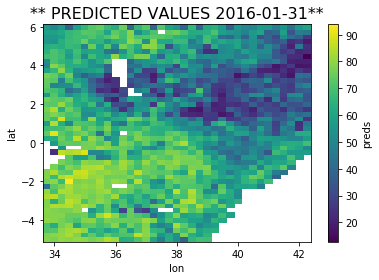

In [288]:
fig, ax = plt.subplots()
time_ix = 0
time = ealstm_pred.isel(time=time_ix).time.values
ealstm_pred.isel(time=time_ix).plot(ax=ax)
ax.set_title(f"** PREDICTED VALUES {str(time).split('T')[0]}**", size=16);

# Read in the models
Input data:
* boku_VCI    
* pev         
* t2m         
* precip      
* E           
* SMroot      
* SMsurf


\+ each variables SPATIAL MEAN (therefore 14 input variables)

In [289]:
from src.models import load_model

In [290]:
ealstm = load_model(data_dir / 'models' / EXPERIMENT / 'ealstm' / 'model.pt')
# lstm = load_model(data_dir / 'models' / EXPERIMENT / 'rnn' / 'model.pt')

In [291]:
ealstm.models_dir = data_dir / 'models' / EXPERIMENT
# lstm.models_dir = data_dir / 'models' / EXPERIMENT

ealstm.experiment = TRUE_EXPERIMENT
ealstm.features_per_month  # x.shape[-1] = the number of features in dynamic data 

16

In [292]:
ealstm.ignore_vars

['p84.162', 'sp', 'tp', 'Eb', 'VCI', 'modis_ndvi']

# checks of the static data

In [293]:
dl = ealstm.get_dataloader('train', batch_file_size=1, shuffle_data=False)
train_iter = iter(dl)
static_data = train_iter.static
static_data

<xarray.Dataset>
Dimensions:                                     (lat: 45, lon: 35)
Coordinates:
  * lat                                         (lat) float32 6.0 5.75 ... -5.0
  * lon                                         (lon) float32 33.75 ... 42.25
Data variables:
    precip_global_mean                          (lat, lon) float64 ...
    E_global_mean                               (lat, lon) float64 ...
    SMroot_global_mean                          (lat, lon) float64 ...
    SMsurf_global_mean                          (lat, lon) float64 ...
    pev_global_mean                             (lat, lon) float64 ...
    t2m_global_mean                             (lat, lon) float64 ...
    precip_pixel_mean                           (lat, lon) float64 ...
    E_pixel_mean                                (lat, lon) float64 ...
    SMroot_pixel_mean                           (lat, lon) float64 ...
    SMsurf_pixel_mean                           (lat, lon) float64 ...
    pev_pixel_mean                              (lat, lon) float64 ...
    t2m_pixel_mean                              (lat, lon) float64 ...
    topography                                  (lat, lon) float32 ...
    lc_class                                    (lat, lon) float64 ...
    lc_class_group                              (lat, lon) int64 ...
    no_data_one_hot                             (lat, lon) float64 ...
    cropland_rainfed_one_hot                    (lat, lon) float64 ...
    herbaceous_cover_one_hot                    (lat, lon) float64 ...
    tree_or_shrub_cover_one_hot                 (lat, lon) float64 ...
    cropland_irrigated_or_postflooding_one_hot  (lat, lon) float64 ...
    tree_cover_one_hot                          (lat, lon) float64 ...
    shrubland_one_hot                           (lat, lon) float64 ...
    grassland_one_hot                           (lat, lon) float64 ...
    lichens_and_mosses_one_hot                  (lat, lon) float64 ...
    urban_areas_one_hot                         (lat, lon) float64 ...
    bare_areas_one_hot                          (lat, lon) float64 ...
    water_bodies_one_hot                        (lat, lon) float64 ...
    permanent_snow_and_ice_one_hot              (lat, lon) float64 ...
    slt                                         (lat, lon) float64 ...

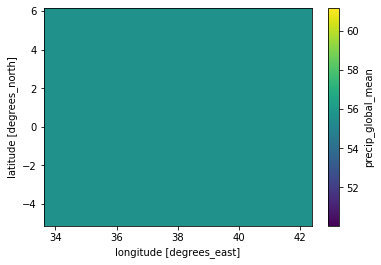

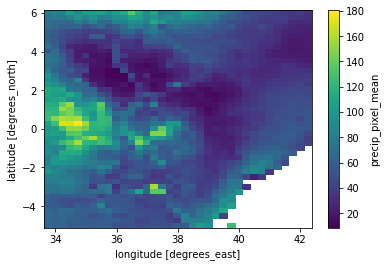

In [294]:
global_vars = [v for v in static_data if 'global' in v]
pixel_vars = [v for v in static_data if 'pixel' in v]

fig, ax = plt.subplots()
static_data[global_vars[0]].plot(ax=ax)
fig, ax = plt.subplots()
static_data[pixel_vars[0]].plot(ax=ax)

# Interpret Model Static layer

In [295]:
dir(ealstm)

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_concatenate_data',
 '_convert_delta_to_raw_values',
 '_get_background',
 '_get_morris_explanations',
 '_get_shap_explanations',
 '_initialize_model',
 '_input_to_tuple',
 '_load_spatial_mask',
 '_make_analysis_folder',
 '_one_hot',
 'batch_size',
 'clear_nans',
 'current_size',
 'data_path',
 'data_vars',
 'denormalize_y',
 'dense_features',
 'device',
 'evaluate',
 'experiment',
 'explain',
 'explainer',
 'features_per_month',
 'get_dataloader',
 'hidden_size',
 'ignore_vars',
 'include_latlons',
 'include_monthly_aggs',
 'include_pred_month',
 'include_prev_y',
 'include_yearly_aggs',
 'input_dense',
 'load',
 'model',
 'model_dir',
 'model_name',
 'models_dir',
 'normalize_y',
 'normalizing_dict',
 'num_locations',
 'pred_months',
 'predict',
 'predict_delta',
 'rnn_dropout',
 'save_model',
 'spatial_mask',
 'static',
 'static_embedding_size',
 'static_size',
 'surrounding_pixels',
 'to',
 'train',
 'yearly_agg_size']

In [296]:
# ealstm.yearly_agg_size
ealstm.model.static_embedding

Linear(in_features=43, out_features=64, bias=True)

In [298]:
from typing import Tuple


def sigmoid(x):
    return 1/(1 + np.exp(-x))


def build_static_x(x: Tuple[np.array], ) -> Tuple[List[np.array], List[np.array], List[np.array]]:
    all_static_x = []
    all_latlons = []
    all_pred_months = []

    for i in range(len(x)):  # EACH BATCH (of X,y pairs)
        pred_month_data = x[i][1]
        latlons_data = x[i][2]
        yearly_aggs_data = x[i][4]
        static_data = x[i][5]
        assert static_data.shape[-1] == 29, f"{static_data.shape}"
        # print()
        # print("pred_month_data.shape", (pred_month_data.shape[0], 12) if pred_month_data is not None else "None")
        # print("latlons_data.shape", latlons_data.shape if latlons_data is not None else "None")
        # print("yearly_aggs_data.shape", yearly_aggs_data.shape if yearly_aggs_data is not None else "None")
        # print("static_data.shape", static_data.shape if static_data is not None else "None")
        # break
        
        # append the static_arrays
        static_x = []
        # normalise latlon
        static_x.append((latlons_data - latlons_data.mean(axis=0)) / latlons_data.std(axis=0))  # 0, 1
        static_x.append(yearly_aggs_data)  # 2: 9
        static_x.append(static_data)
        # one_hot_encode the pred_month_data
        try:
            static_x.append(ealstm._one_hot(torch.from_numpy(pred_month_data), 12).numpy())
        except TypeError:
            static_x.append(ealstm._one_hot(torch.from_numpy(pred_month_data), 12).cpu().numpy())
        
        # exclude Nones
        static_x = np.concatenate([x for x in static_x if x is not None], axis=-1)
        # print("Static X Data Shape: ", static_x.shape)
        
        # all data
        all_static_x.append(static_x)

        # metadata (latlons and pred_months)
        all_latlons.append(latlons_data)
        all_pred_months.append(pred_month_data)
        
    return all_static_x, all_latlons, all_pred_months


def calculate_embeddings(static_x: np.ndarray, W: np.ndarray, b: np.array) -> np.array:
    assert W.T.shape[0] == static_x.shape[-1], f"Matrix operations must be valid {static_x.shape} * {W.T.shape}"
    
    embedding = []
    for pixel_ix in range(static_x.shape[0]):
        embedding.append(sigmoid(np.dot(W, static_x[pixel_ix]) + b))
    return np.array(embedding)


def get_train_mask(ealstm):
    val_split = 0.1
    len_mask = len(
        DataLoader._load_datasets(
            ealstm.data_path,
            mode="train",
            experiment=EXPERIMENT,
            shuffle_data=False,
            pred_months=None,
        )
    )
    train_mask, val_mask = train_val_mask(len_mask, val_split)
    return train_mask


def get_static_embedding(ealstm) -> Tuple[List[np.array], Tuple[List[np.array], np.array, List[np.array]]]:
    # get W, b from state_dict
    od = ealstm.model.static_embedding.state_dict()
    try:
        W = od['weight'].numpy()
        b = od['bias'].numpy()
    except TypeError:
        W = od['weight'].cpu().numpy()
        b = od['bias'].cpu().numpy()
        
    # get X_static data from dataloader
    print("Calling Training DataLoader")
    dl = ealstm.get_dataloader('train', batch_file_size=1, shuffle_data=False)
    x = [x for (x, y) in dl]
        
    # build static_x matrix
    all_static_x, all_latlons, all_pred_months = build_static_x(x)
    # check w^Tx + b is a valid matrix operation
    assert W.T.shape[0] == all_static_x[0].shape[-1], f"W.T shape: {W.T.shape} static_x shape: {all_static_x[0].shape}"
    
    # calculate the embeddings
    all_embeddings = []
    for static_x in all_static_x:
        embedding = calculate_embeddings(static_x, W=W, b=b)
        all_embeddings.append(embedding)
        
    return all_embeddings, (all_static_x, np.array(all_latlons), np.array(all_pred_months))

all_e, (all_static_x, all_latlons, all_pred_months) = get_static_embedding(ealstm=ealstm)

Calling Training DataLoader
data/features/one_month_forecast/train/2002_3 returns no values. Skipping
data/features/one_month_forecast/train/2002_4 returns no values. Skipping


#### TODO: why do these exist?
Remove the static months where there are more than one pred_months

In [299]:
pred_months_err_mask = [len(np.unique(pm)) == 1 for pm in all_pred_months]
all_e = np.array(all_e)[pred_months_err_mask]
all_static_x = np.array(all_static_x)[pred_months_err_mask]
all_pred_months = np.array(all_pred_months)[pred_months_err_mask]
all_latlons = np.array(all_latlons)[pred_months_err_mask]

assert all_latlons.shape == all_static_x.shape
assert all_pred_months.shape == all_e.shape

# assert all timsteps have only 1 pred month
assert all([i == 1 for i in [len(np.unique(pm)) for pm in all_pred_months]])

### Sort by the pred month

In [300]:
# SORTBY month
pred_months = [int(np.unique(pm)) for pm in all_pred_months]

def sort_by_another_list(list_to_sort, list_to_sort_on):
    assert len(list_to_sort) == len(list_to_sort_on)
    sort_ixs = np.argsort(list_to_sort_on)
    return list_to_sort[sort_ixs]

all_e = sort_by_another_list(all_e, pred_months)
all_static_x = sort_by_another_list(all_static_x, pred_months)
all_latlons = sort_by_another_list(all_latlons, pred_months)
all_pred_months = sort_by_another_list(all_pred_months, pred_months)

In [355]:
print(len(all_e))
[emb.shape for emb in all_e]
print(len(all_latlons))

160
160


# Are they actually Static?

In [314]:
pred_months = [int(np.unique(pm)) for pm in all_pred_months]
pred_months

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12]

In [335]:
unique_ids = [pred_months.index(x) for x in set(pred_months)]

for id_1, id_2 in zip(unique_ids, [id_ + 1 for id_ in unique_ids]):
    if all_e[id_1].shape == all_e[id_2].shape:
        print(np.all(all_e[id_1] == all_e[id_2]))
    elif all_e[id_1].shape == all_e[id_2 + 1].shape:
        print(np.all(all_e[id_1] == all_e[id_2 + 1]))
    elif all_e[id_1].shape == all_e[id_2 + 2].shape:
        print(np.all(all_e[id_1] == all_e[id_2 + 2]))
    elif all_e[id_1].shape == all_e[id_2 + 3].shape:
        print(np.all(all_e[id_1] == all_e[id_2 + 3]))
    elif all_e[id_1].shape == all_e[id_2 + 4].shape:
        print(np.all(all_e[id_1] == all_e[id_2 + 4]))

True
True
True
True
True
True
True
True
False
True


In [349]:
unique_ids = [pred_months.index(x) for x in set(pred_months)]

month_embeddings = all_e[unique_ids]
month_static_x = all_static_x[unique_ids]
month_latlons = all_latlons[unique_ids]
month_pred_months = all_pred_months[unique_ids]
month_pred_months = [np.unique(m)[0] for m in month_pred_months]

In [319]:
len(month_embeddings)

12

# Visualise the Static Embedding

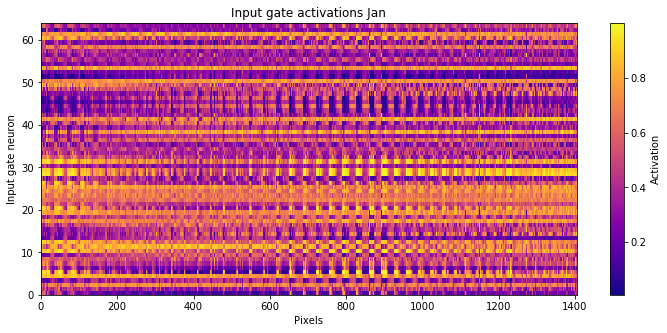

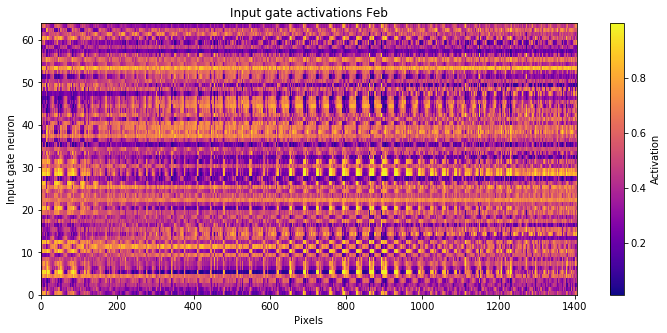

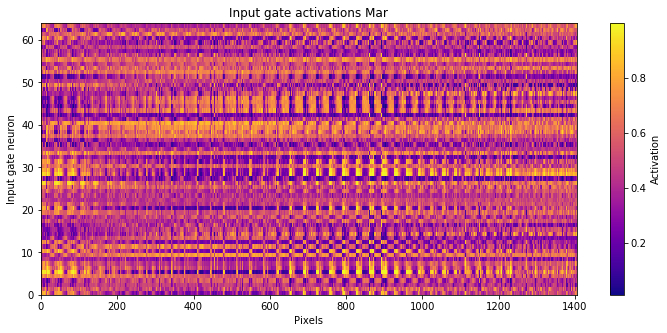

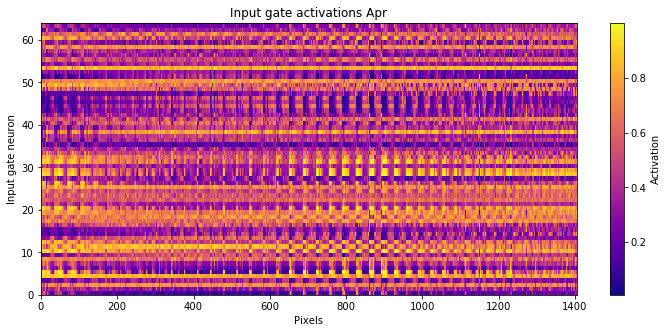

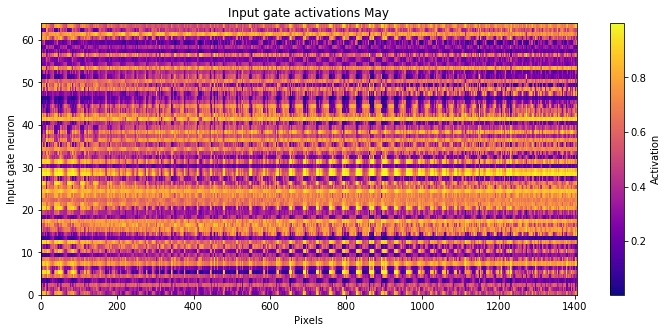

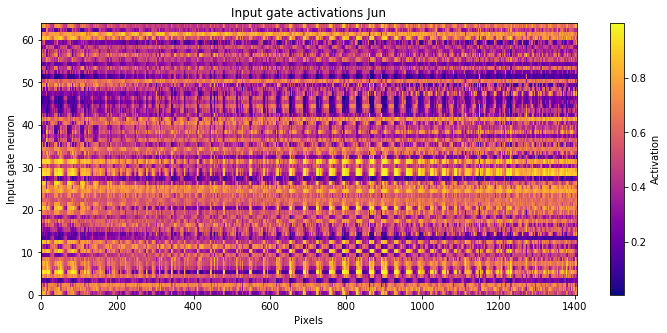

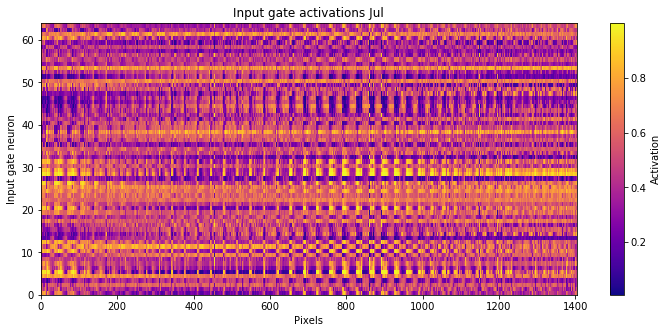

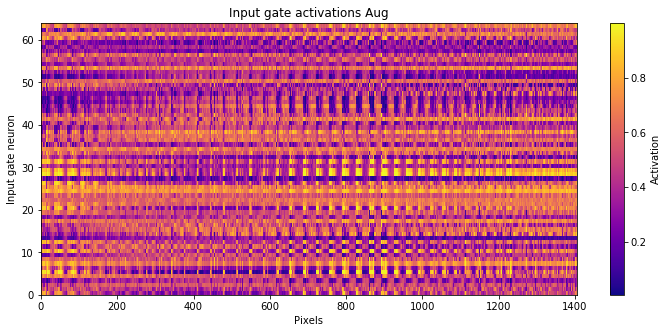

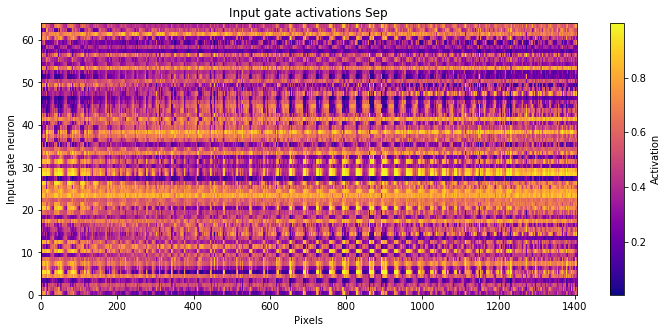

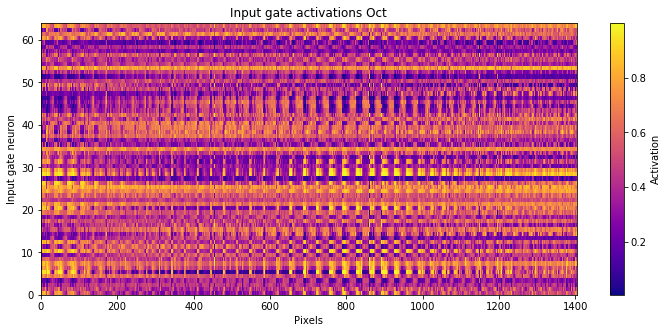

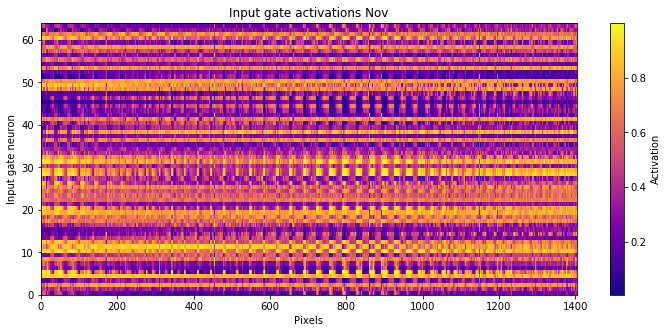

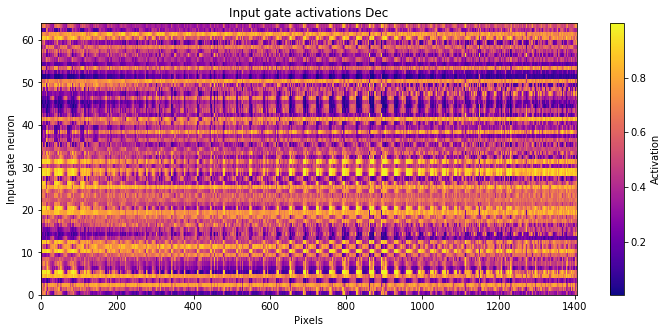

In [338]:
import calendar

for embedding, pred_month in zip(month_embeddings, month_pred_months):
    # embedding = all_embeddings[0]
    fig, ax = plt.subplots(figsize=(12,5))
    img = ax.pcolor(embedding.T, cmap='plasma')
    ax.set_xlabel("Pixels")
    ax.set_ylabel("Input gate neuron")
    month = [m for m in calendar.month_abbr][pred_month]
    ax.set_title(f"Input gate activations {month}")
    cbar = plt.colorbar(img, ax=ax)
    cbar.ax.set_ylabel("Activation")

In [306]:
# create embedding dataset
def build_xarray_object(embedding_matrix: np.array, ix):
    return (
        pd.DataFrame(embedding_matrix)
        .reset_index()
        .rename(columns={'index': 'pixel'})
        .melt(id_vars='pixel')
        .rename(columns={'variable': 'neuron', 'value': f'activation_{ix:03d}'})
        .set_index(['pixel', 'neuron'])
        .to_xarray()
    )

all_ds = []
for ix, embedding_matrix in enumerate(all_e):
    all_ds.append(build_xarray_object(embedding_matrix, ix))
    break
    
ds = xr.auto_combine(all_ds)
ds

<xarray.Dataset>
Dimensions:         (neuron: 64, pixel: 1404)
Coordinates:
  * pixel           (pixel) int64 0 1 2 3 4 5 ... 1398 1399 1400 1401 1402 1403
  * neuron          (neuron) int64 0 1 2 3 4 5 6 7 8 ... 56 57 58 59 60 61 62 63
Data variables:
    activation_000  (pixel, neuron) float64 0.4045 0.6835 ... 0.3171 0.7132

# How does this vary over each MONTH ?

In [339]:
# Taken directly from Kratzert et al (2019) 
# https://github.com/kratzert/ealstm_regional_modeling/blob/master/papercode/clusterutils.py
from collections import defaultdict
from typing import List, Dict, Union
from sklearn.cluster import KMeans


def fit_kmeans(array: np.array, ks: List[int] = [4]) -> Dict[int, Dict[int, int]]:
    clusters = {k: {} for k in ks}
    for k in ks:
        clusterer = KMeans(n_clusters=k, random_state=0, init='k-means++',
                           n_init=200).fit(array)

        for pixel in range(array.shape[0]):
            arr = array[pixel, :]
            clusters[k][pixel] = clusterer.predict(arr.reshape(1, -1))[0]
    return clusters


def convert_clusters_to_ds(ks: List[int], static_clusters: Dict[int, np.array], pixels: np.ndarray, latitudes: np.ndarray, longitudes: np.ndarray, time: Union[pd.Timestamp, int] = 1) -> xr.Dataset:
    out = []
    for k in ks:
        cluster = np.array([v for v in static_clusters[k].values()])
        coords = {'pixel': pixels}
        dims = ['pixel']
        cluster_ds = xr.Dataset({f'cluster_{k}': (dims, cluster), 'lat': (dims, latitudes), 'lon': (dims, longitudes), 'time': (dims, [time for _ in range(len(latitudes))])})
        out.append(cluster_ds)
    
    static_cluster_ds = xr.auto_combine(out)
    static_cluster_ds = static_cluster_ds.to_dataframe().set_index(['time', 'lat','lon']).to_xarray()
    
    return static_cluster_ds


def plot_cluster_ds(ks: List[int], static_cluster_ds: xr.Dataset, month_abbr: str = ''):
    for k in ks:
        fig, ax = plt.subplots(figsize=(12,8))
        static_cluster_ds[f'cluster_{k}'].plot(ax=ax)
        ax.set_title(f'Output of Static Embedding Clustering [k={k}]\n{month_abbr}');

        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]): # + ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(20)

In [344]:
# len(all_e)
# embedding.shape
# latlons.shape

print(len(month_embeddings))
print(len(month_pred_months))
print(len(month_latlons))

12
12
12


In [351]:
# n clusters 

# calculate clusters for ALL x.nc inputs
all_cluster_ds = []

for ix, (embedding, pred_month, latlons) in enumerate(zip(
    month_embeddings, 
    month_pred_months, 
    month_latlons
)):
    ks = [5]
    
    # fit the clusters
    static_clusters = fit_kmeans(embedding, ks)
    print(f"Fitted KMeans {ix}") if ix % 10 == 0 else None
    
    # convert to dataset
    pixels = latlons
    lons = latlons[:, 1] 
    lats = latlons[:, 0] 
    static_cluster_ds = convert_clusters_to_ds(ks, static_clusters, pixels, lats, lons, time=ix)
    print(f"Convert to ds {ix}") if ix % 10 == 0 else None
    
    # append to final list
    all_cluster_ds.append(static_cluster_ds)

# combine into one xr.Dataset
cluster_ds = xr.auto_combine(all_cluster_ds)

Fitted KMeans 0
Convert to ds 0
Fitted KMeans 10
Convert to ds 10


In [352]:
cluster_ds

<xarray.Dataset>
Dimensions:    (lat: 45, lon: 35, time: 12)
Coordinates:
  * lat        (lat) float64 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.25 5.5 5.75 6.0
  * lon        (lon) float64 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    cluster_5  (time, lat, lon) float64 3.0 3.0 0.0 3.0 3.0 ... 2.0 2.0 2.0 2.0

In [354]:
cluster_ds.to_netcdf(data_dir / f"tommy/static_embeddings.nc")

# Plot KMeans for each of the embeddings
TODO: Get the colors the same like the Kratzert code!

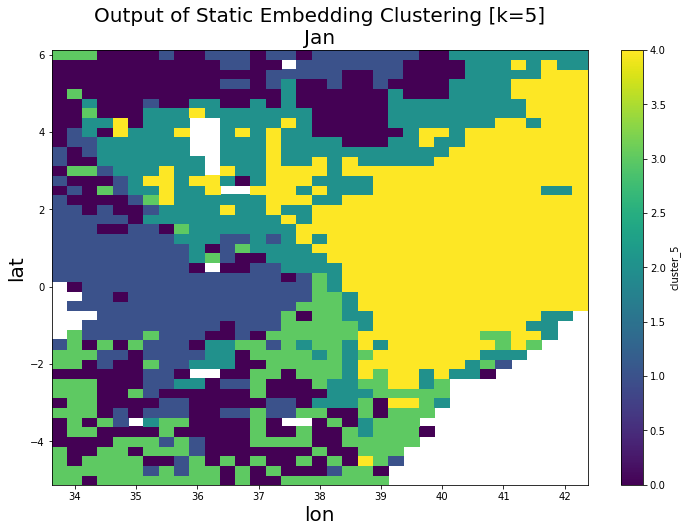

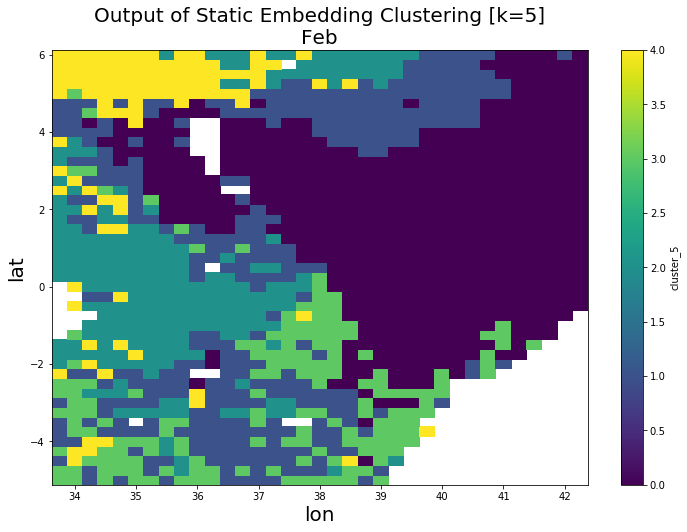

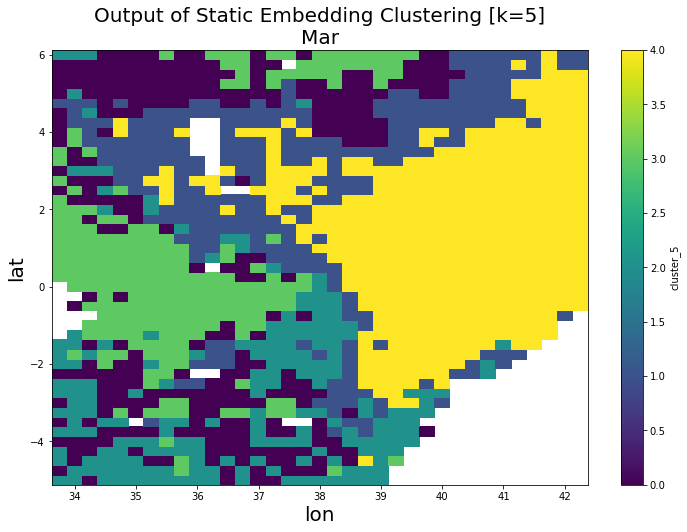

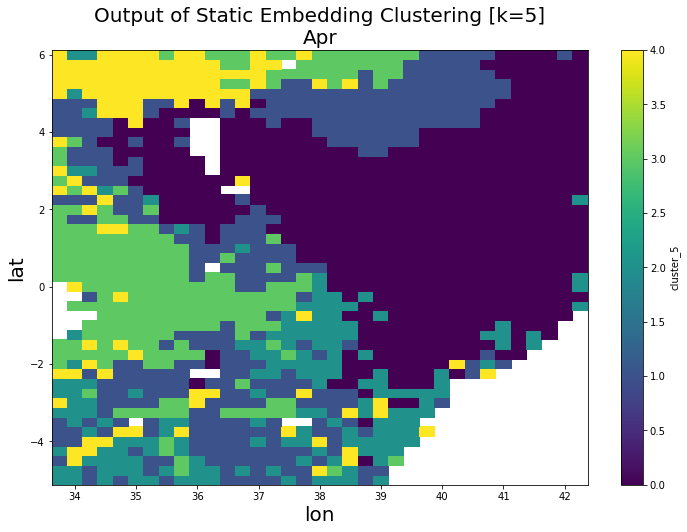

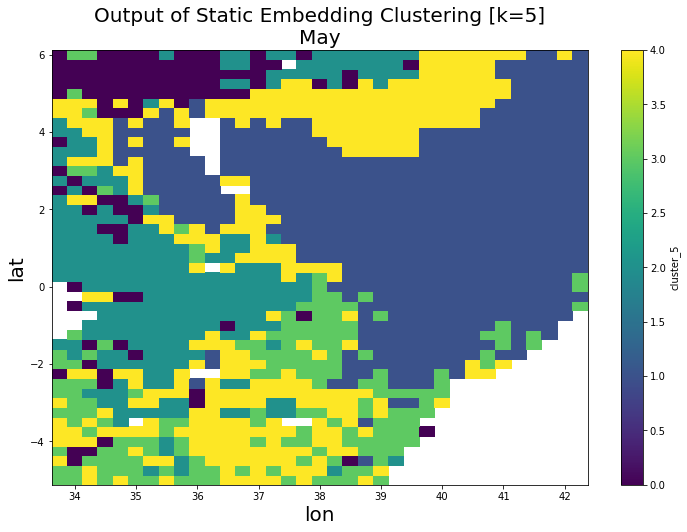

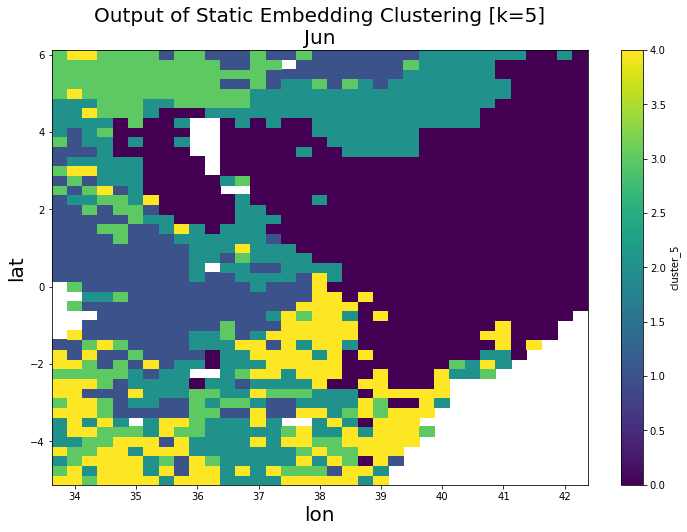

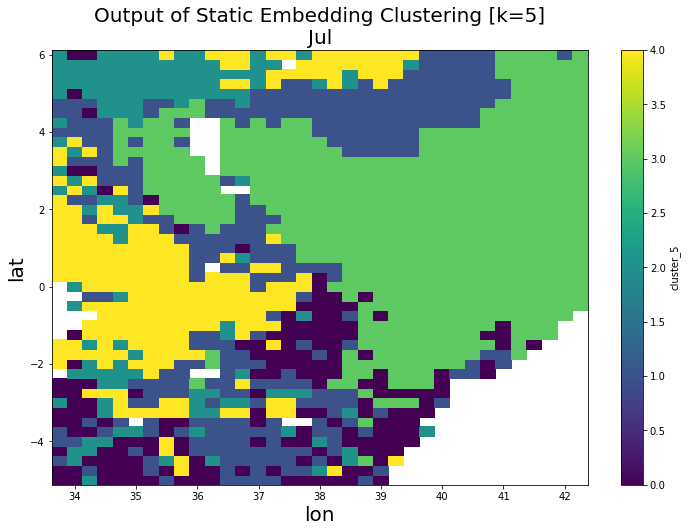

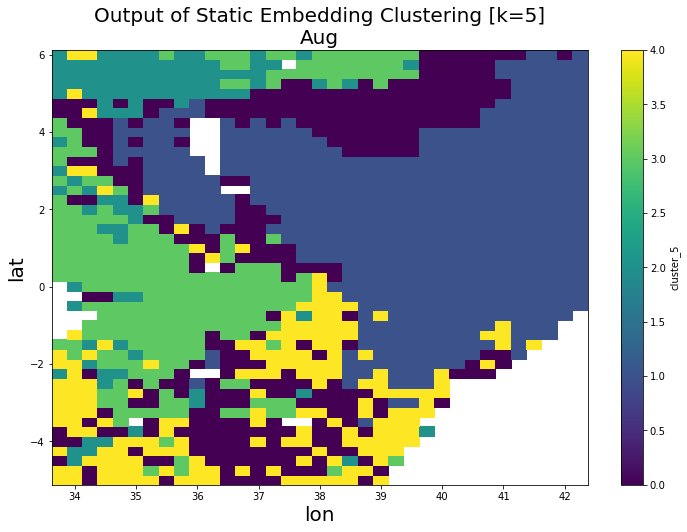

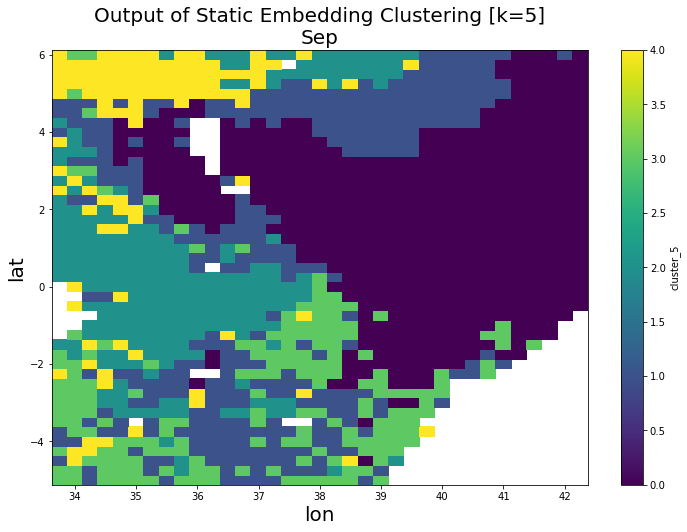

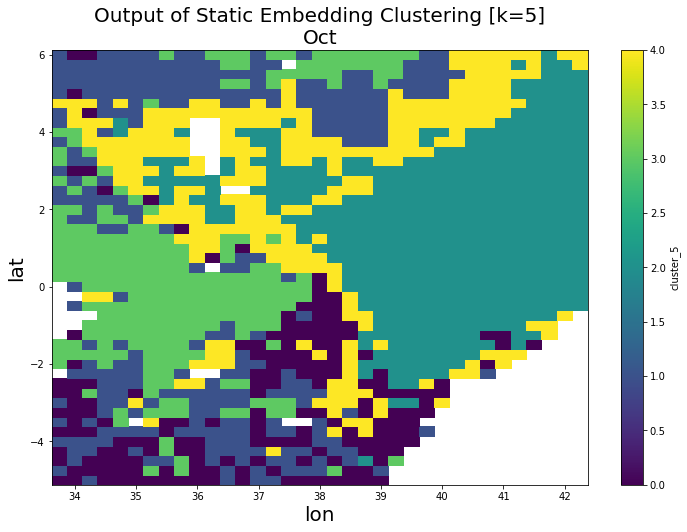

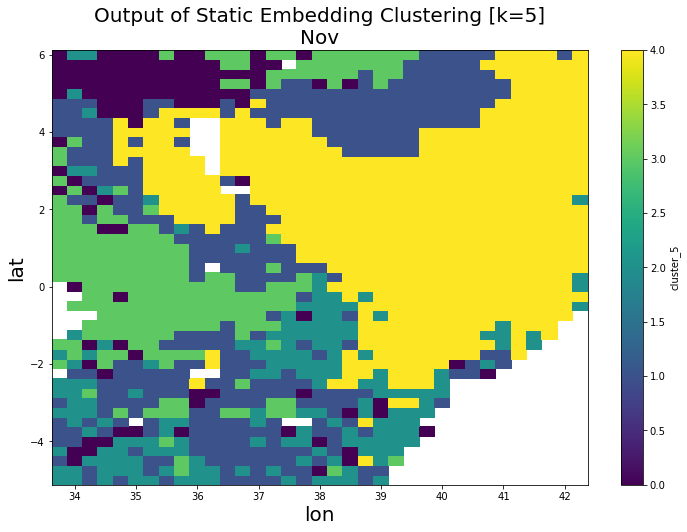

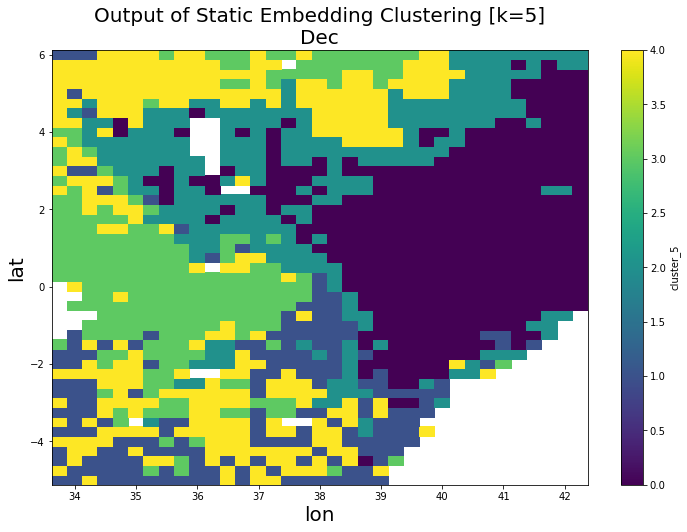

In [353]:
m_abbrs = [m for m in calendar.month_abbr]

yr = 1
yr = max(1, yr)
min_ix = 1  # 2 + (12 * (yr - 1))
max_ix = 4  # 14 + (12 * (yr - 1))

for embedding, pred_month, latlons in zip(
    month_embeddings, 
    month_pred_months, 
    month_latlons
):
    ks = [5]
    static_clusters = fit_kmeans(embedding, ks)
    
    # create ds
    pixels = latlons
    lons = latlons[:, 1] 
    lats = latlons[:, 0] 
    static_cluster_ds = convert_clusters_to_ds(ks, static_clusters, pixels, lats, lons)
    
    # plot ds
    month_abbr = m_abbrs[pred_month]
    plot_cluster_ds(ks, static_cluster_ds, month_abbr=month_abbr)
#     fig = plt.gcf()
#     fig.savefig(plot_dir/f'kmeans_cluster_{month_abbr}.png')

# MARGINALIA

In [ ]:
latitudes = latlons_data[:, 0]
longitudes = latlons_data[:, 1]
pixels = latlons

out = []
for k in ks:
    cluster = np.array([v for v in static_clusters[k].values()])
    coords = {'pixel': pixels}
    dims = ['pixel']
    cluster_ds = xr.Dataset({f'cluster_{k}': (dims, cluster), 'lat': (dims, latitudes), 'lon': (dims, longitudes),})
    out.append(cluster_ds)

static_cluster_ds = xr.auto_combine(out)
static_cluster_ds = static_cluster_ds.to_dataframe().set_index(['lat','lon']).to_xarray()

In [ ]:
# latitudes = latlons_data[:, 0]
# longitudes = latlons_data[:, 1]
pixels = latlons
convert_clusters_to_ds(ks, static_clusters=static_clusters, pixels=pixels)
pixels

### [UNNECESSARY] which of these neurons actually vary?

In [ ]:
threshold = 0.01

embedding = all_embeddings[0]
mask_same = np.all(np.isclose(embedding, embedding[0,:], threshold), axis=0)
print(f"How many neurons have the same values (thresh {threshold}): ".ljust(58), mask_same.sum())
print(f"How many neurons are left: ".ljust(58), len(mask_same) - mask_same.sum())
remove_constants = embedding[:, ~mask_same]

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
pd.DataFrame({'std': np.std(embedding, axis=0)}, index=np.arange(0, 64)).plot.bar(ax=ax)

plt.legend(fontsize=16)
ax.set_title('Variability of the Static Embedding')
ax.set_ylabel('Standard Deviation')
ax.set_xlabel('Neuron')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] # + ax.get_xticklabels()
              + ax.get_yticklabels()):
    item.set_fontsize(20)

### Remove the Non-Varying neurons

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
img = ax.pcolor(remove_constants.T, cmap='plasma')
ax.set_xlabel("Pixels")
ax.set_ylabel("Input gate neuron")
ax.set_title("Input gate activations")
cbar = plt.colorbar(img, ax=ax)
cbar.ax.set_ylabel("Activation")

# KMeans on the Embeddings

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
# Taken directly from Kratzert et al (2019) 
# https://github.com/kratzert/ealstm_regional_modeling/blob/master/papercode/clusterutils.py
from collections import defaultdict

ks = [3, 4, 5, 8]
clusters = {k: {} for k in ks}
for k in ks:
    clusterer = KMeans(n_clusters=k, random_state=0, init='k-means++',
                       n_init=200).fit(embedding)

    for pixel in range(embedding.shape[0]):
        emb = embedding[pixel, :]
        clusters[k][pixel] = clusterer.predict(emb.reshape(1, -1))[0]

In [ ]:
np.array([v for v in clusters[5].values()]).shape

In [ ]:
latitudes = latlons_data[:, 0]
longitudes = latlons_data[:, 1]
pixels = latlons

out = []
for k in ks:
    cluster = np.array([v for v in clusters[k].values()])
    coords = {'pixel': pixels}
    dims = ['pixel']
    cluster_ds = xr.Dataset({f'cluster_{k}': (dims, cluster), 'lat': (dims, latitudes), 'lon': (dims, longitudes),})
    out.append(cluster_ds)

cluster_ds = xr.auto_combine(out)
cluster_ds = cluster_ds.to_dataframe().set_index(['lat','lon']).to_xarray()

In [ ]:
for k in ks:
    fig, ax = plt.subplots(figsize=(12,8))
    cluster_ds[f'cluster_{k}'].plot(ax=ax)
    ax.set_title(f'Output of Static Embedding Clustering [k={k}]');

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]): # + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)

# Compare with the output of the raw static data 
(what info does the EALSTM embedding actually contribute?)

In [ ]:
print(static_x.shape)
print(embedding.shape)

In [ ]:
# Taken directly from Kratzert et al (2019) 
# https://github.com/kratzert/ealstm_regional_modeling/blob/master/papercode/clusterutils.py
from collections import defaultdict

ks = [3, 4, 5, 8]
# def fit_kmeans(array: np.array, ks: List[int] = [4]) -> Dict[int, Dict[int, int]]:
static_clusters = {k: {} for k in ks}
for k in ks:
    clusterer = KMeans(n_clusters=k, random_state=0, init='k-means++',
                       n_init=200).fit(static_x)

    for pixel in range(embedding.shape[0]):
        emb = static_x[pixel, :]
        static_clusters[k][pixel] = clusterer.predict(emb.reshape(1, -1))[0]

In [ ]:
np.array([v for v in static_clusters[5].values()]).shape

In [ ]:
latitudes = latlons_data[:, 0]
longitudes = latlons_data[:, 1]
pixels = latlons

out = []
for k in ks:
    cluster = np.array([v for v in static_clusters[k].values()])
    coords = {'pixel': pixels}
    dims = ['pixel']
    cluster_ds = xr.Dataset({f'cluster_{k}': (dims, cluster), 'lat': (dims, latitudes), 'lon': (dims, longitudes),})
    out.append(cluster_ds)

static_cluster_ds = xr.auto_combine(out)
static_cluster_ds = static_cluster_ds.to_dataframe().set_index(['lat','lon']).to_xarray()

In [ ]:
for k in ks:
    fig, ax = plt.subplots(figsize=(12,8))
    static_cluster_ds[f'cluster_{k}'].plot(ax=ax)
    ax.set_title(f'Output of RAW Static Data Clustering [k={k}]');

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]): # + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)

# Get Morris Gradients

In [ ]:
?ealstm.get_dataloader

In [ ]:
ealstm.ignore_vars =[v for v in ealstm.ignore_vars if v not in ['VCI3M', 'modis_ndvi']]
dl = ealstm.get_dataloader('train')
x = [x for x in dl]

In [ ]:
print(x[0][0][5][:10])
print(x[1][0][5][:10])

In [ ]:
test_arrays_loader = ealstm.get_dataloader(
                mode="train", batch_file_size=1, to_tensor=True
)
_, val = list(next(iter(test_arrays_loader)).items())[0]
var_names = val.var_names
x = val.x

In [ ]:
?ealstm._get_morris_explanations

In [ ]:
ealstm.explain(method='morris')